In [2]:
from utils.augmentation import Cutout_jitter_aug
import torch
import pandas as pd
import numpy as np
from scipy.signal.windows import gaussian
from scipy.stats import beta
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
import pickle
from utils.CMixUp_algorithm import get_batch_kde_mixup_batch, get_batch_kde_mixup_idx
from sklearn.neighbors import KernelDensity


In [1]:
def f_1(a_list):
    a_list[0] = 'Y'

a_list = [1 ,2]
f_1(a_list)
print(a_list)

['Y', 2]


In [101]:
from layers.MOE_dispatcher import MOEDispatcher
logits = torch.rand(2, 3)
logits[:, -1] = -10000000000
x = torch.rand(3, 6)
_, indices = torch.topk(logits, 2, dim=1)
# Create a mask where only the top-K values will be kept
mask = torch.zeros_like(logits, dtype=torch.bool)
# Scatter the mask at the indices of the top-K values
mask.scatter_(1, indices, 1)
# Set all values that are not top-K to zero
logits = logits * mask.float()
dispatcher = MOEDispatcher(6, logits)
MOE_indicies = dispatcher.dispatch()
print(MOE_indicies)
total_dec_outs = []
for i in range(logits.shape[1]):
    dec_out = x[MOE_indicies[i]]
    total_dec_outs.append(dec_out)
total_dec_outs = dispatcher.combine(total_dec_outs) # [B, d_llm]
total_dec_outs.shape

(tensor([0, 1]), tensor([0, 1]), tensor([], dtype=torch.int64))
torch.Size([4, 6])


torch.Size([2, 6])

In [9]:
sequence_length = 3
target_length = 3
device="cpu"
batch_size = 2
attention_mask = torch.ones((batch_size, sequence_length)).long()
attention_mask[:,0] = 0
dtype = torch.float
cache_position = torch.arange(
    0, 0 + sequence_length, device=device
)
min_dtype = torch.finfo(dtype).min
causal_mask = torch.full(
    (sequence_length, target_length), fill_value=min_dtype, dtype=dtype, device="cpu"
)
if sequence_length != 1:
    causal_mask = torch.triu(causal_mask, diagonal=1)
causal_mask *= torch.arange(target_length, device=device) > cache_position.reshape(-1, 1)
causal_mask = causal_mask[None, None, :, :].expand(batch_size, 1, -1, -1)
print(causal_mask)
if attention_mask is not None:
    causal_mask = causal_mask.clone()  # copy to contiguous memory for in-place edit
    mask_length = attention_mask.shape[-1]
    padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[:, None, None, :]
    print('padding',padding_mask)
    padding_mask = padding_mask == 0
    print('padding',padding_mask)
    causal_mask[:, :, :, :mask_length] = causal_mask[:, :, :, :mask_length].masked_fill(
        padding_mask, min_dtype 
    )
causal_mask

tensor([[[[ 0.0000e+00, -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[ 0.0000e+00, -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00, -3.4028e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]]])
padding tensor([[[[ 0.0000e+00, -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  1.0000e+00, -3.4028e+38],
          [ 0.0000e+00,  1.0000e+00,  1.0000e+00]]],


        [[[ 0.0000e+00, -3.4028e+38, -3.4028e+38],
          [ 0.0000e+00,  1.0000e+00, -3.4028e+38],
          [ 0.0000e+00,  1.0000e+00,  1.0000e+00]]]])
padding tensor([[[[ True, False, False],
          [ True, False, False],
          [ True, False, False]]],


        [[[ True, False, False],
          [ True, False, False],
          [ True, False, False]]]])


tensor([[[[-3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-3.4028e+38,  0.0000e+00, -3.4028e+38],
          [-3.4028e+38,  0.0000e+00,  0.0000e+00]]],


        [[[-3.4028e+38, -3.4028e+38, -3.4028e+38],
          [-3.4028e+38,  0.0000e+00, -3.4028e+38],
          [-3.4028e+38,  0.0000e+00,  0.0000e+00]]]])

In [63]:
import torch

def generate_monotonic_sequence(length, start, end):
    # Ensure length is at least 2 to accommodate start and end
    assert length >= 2, "Length must be at least 2 to include start and end values."

    # Create random increments
    random_increments = torch.rand(length)

    # Cumulative sum to get a monotonically increasing sequence
    sequence = torch.cumsum(random_increments, dim=0)

    # Normalize the sequence to fit the desired start and end values
    sequence = sequence - sequence.min()  # Make the sequence start from 0
    sequence = sequence / sequence.max()  # Scale it to end at 1

    # Scale to the desired range [start, end]
    sequence = sequence * (end - start) + start


    return sequence

def linear_interpolate_multi(x_target, x_source, y_source):
    """
    Perform linear interpolation for given target x-values based on source x and multi-dimensional y values.

    :param x_target: The x-coordinates where interpolation is evaluated.
    :param x_source: The x-coordinates of the data points, must be increasing.
    :param y_source: The y-coordinates of the data points with shape [L, D].
    :return: Interpolated y-values at x_target with shape [len(x_target), D].
    """
    # Ensure x_source is increasing
    if not torch.all(x_source[1:] > x_source[:-1]):
        raise ValueError("x_source must be strictly increasing")

    # Find indices of the intervals for each x_target
    indices = torch.searchsorted(x_source, x_target, right=True) - 1
    indices = torch.clamp(indices, 0, len(x_source) - 2)

    # Gather the corresponding x values for interpolation
    x0 = x_source[indices]
    x1 = x_source[indices + 1]

    # Gather the corresponding y values for interpolation
    y0 = y_source[indices]
    y1 = y_source[indices + 1]

    # Calculate the slope (m) for each segment and dimension
    m = (y1 - y0) / (x1.unsqueeze(-1) - x0.unsqueeze(-1))

    # Compute the interpolated values for each dimension
    y_interpolated = m * (x_target.unsqueeze(-1) - x0.unsqueeze(-1)) + y0

    return y_interpolated

def linear_interpolate_batch(x_target, x_source, y_source):
    """
    Perform linear interpolation for a batch of sequences with given target x-values.

    :param x_target: The x-coordinates where interpolation is evaluated (1D tensor).
    :param x_source: The x-coordinates of the data points (1D tensor, must be increasing).
    :param y_source: The y-coordinates of the data points with shape [N, L, D].
    :return: Interpolated y-values at x_target with shape [N, len(x_target), D].
    """
    N, L, D = y_source.shape

    # Ensure x_source is increasing
    if not torch.all(x_source[1:] > x_source[:-1]):
        raise ValueError("x_source must be strictly increasing")

    # Find indices of the intervals for each x_target
    indices = torch.searchsorted(x_source, x_target, right=True) - 1
    indices = torch.clamp(indices, 0, L - 2)

    # Gather the corresponding x values for interpolation
    x0 = x_source[indices]
    x1 = x_source[indices + 1]

    # Expand indices for batch processing
    indices_expanded = indices.unsqueeze(0).expand(N, -1)

    # Gather the corresponding y values for interpolation
    y0 = y_source[torch.arange(N).unsqueeze(1), indices_expanded]
    y1 = y_source[torch.arange(N).unsqueeze(1), indices_expanded + 1]

    # Calculate the slope (m) for each segment and dimension
    m = (y1 - y0) / (x1.unsqueeze(-1) - x0.unsqueeze(-1))

    # Compute the interpolated values for each dimension
    y_interpolated = m * (x_target.unsqueeze(-1).unsqueeze(0) - x0.unsqueeze(-1)) + y0

    return y_interpolated

# Example usage
length = 10  # Total number of elements in the sequence
start = 0
end = length-1

X_source = torch.arange(start=start, end=end+1, step=1)
X_target = generate_monotonic_sequence(length, start, end)
print(X_source.shape, X_target.shape)

tmp = X_source.unsqueeze(-1)
Y_source = torch.cat([tmp, tmp, tmp], dim=1)
Y_target = linear_interpolate_multi(X_target, X_source, Y_source)
print(Y_target)
X_target2 = generate_monotonic_sequence(length, start, end)
Y_target2 = linear_interpolate_multi(X_target2, X_source, Y_source)
print(Y_target2)

torch.Size([10]) torch.Size([10])
tensor([[0.0000, 0.0000, 0.0000],
        [0.1194, 0.1194, 0.1194],
        [0.5053, 0.5053, 0.5053],
        [0.8409, 0.8409, 0.8409],
        [1.6455, 1.6455, 1.6455],
        [3.4775, 3.4775, 3.4775],
        [3.4992, 3.4992, 3.4992],
        [4.3365, 4.3365, 4.3365],
        [6.7521, 6.7521, 6.7521],
        [9.0000, 9.0000, 9.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [1.8836, 1.8836, 1.8836],
        [2.5311, 2.5311, 2.5311],
        [3.4145, 3.4145, 3.4145],
        [5.1762, 5.1762, 5.1762],
        [5.3149, 5.3149, 5.3149],
        [6.2749, 6.2749, 6.2749],
        [6.9654, 6.9654, 6.9654],
        [8.9371, 8.9371, 8.9371],
        [9.0000, 9.0000, 9.0000]])


In [64]:
def get_mixup_sample_rate(args, data_packet, use_kde = False):
    
    mix_idx = []
    y_list = data_packet['y_train'] 
    data_list = y_list
    # is_np = isinstance(y_list,np.ndarray)
    # if is_np:
    #     data_list = torch.tensor(y_list, dtype=torch.float32)
    # else:
    #     data_list = y_list

    N = len(data_list)

    ######## use kde rate or uniform rate #######
    for i in range(N):
        data_i = data_list[i]
        data_i = data_i.reshape(-1,data_i.shape[0]) # get 2D
        
            
        ######### get kde sample rate ##########
        kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data_i)  # should be 2D
        each_rate = np.exp(kd.score_samples(data_list))
        each_rate /= np.sum(each_rate)  # norm
        
        mix_idx.append(each_rate)

    mix_idx = np.array(mix_idx)

    return mix_idx

In [65]:
labels = torch.rand(16,1)
Batch_packet = {}
Batch_packet['y_train'] = labels.cpu()
Batch_rate = get_mixup_sample_rate(None, Batch_packet, use_kde=True) # batch -> kde
Batch_rate.shape

(16, 16)

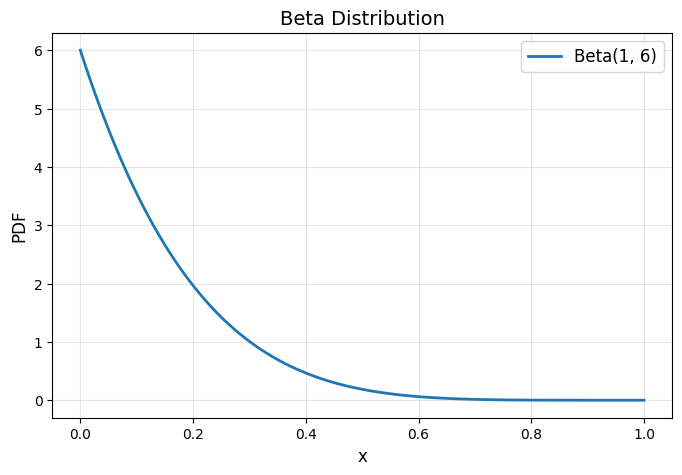

In [66]:
# Define the shape parameters for the Beta distribution
alpha, beta_param = 1, 6  # Example values

# Generate x values (the range of the Beta distribution is [0, 1])
x = np.linspace(0, 1, 100)

# Calculate the probability density function (PDF) for the Beta distribution
pdf = beta.pdf(x, alpha, beta_param)

# Plot the Beta distribution
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label=f'Beta({alpha}, {beta_param})', lw=2)
plt.title('Beta Distribution', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('PDF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [67]:
%matplotlib inline

In [68]:
data = pickle.load(open('/data/trf/python_works/Battery-LLM/dataset/HUST/HUST_1-3.pkl', 'rb'))
data2 = pickle.load(open('/data/trf/python_works/Battery-LLM/dataset/HNEI/HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a.pkl', 'rb'))
cylce_data = data['cycle_data']
cylce_data2 = data2['cycle_data']

In [69]:
print(len(cylce_data))

1858


In [70]:
df = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data[10]
for key in need_keys:
    df[key] = sub_cycle_data[key]

df2 = pd.DataFrame()
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
sub_cycle_data = cylce_data2[10]
for key in need_keys:
    df2[key] = sub_cycle_data[key]

df2 = df2.loc[df2['current_in_A']<0]
voltages2 = df2['voltage_in_V'].values
currents2 = df2['current_in_A'].values

In [71]:
window_size = 15
gaussian_kernel = torch.FloatTensor(gaussian(window_size,std=11))
print(gaussian_kernel)

tensor([0.8167, 0.8618, 0.9019, 0.9360, 0.9635, 0.9836, 0.9959, 1.0000, 0.9959,
        0.9836, 0.9635, 0.9360, 0.9019, 0.8618, 0.8167])


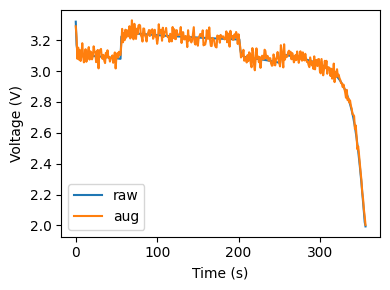

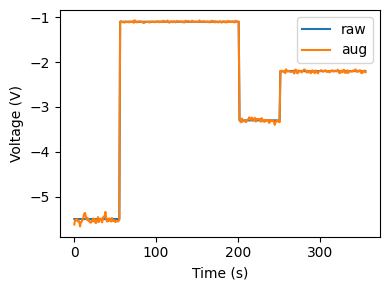

In [72]:
df = df.loc[df['current_in_A']<0]
voltages = df['voltage_in_V'].values
currents = df['current_in_A'].values
fig = plt.figure(figsize=(4,3))
plt.plot(np.arange(0,len(voltages)), voltages, label='raw')
X = torch.Tensor(voltages)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
my_cutout = Cutout_jitter_aug(10, 5)
noise_voltages = my_cutout(X)
noise_voltages = noise_voltages.squeeze(0).squeeze(-1)
plt.plot(np.arange(0,len(noise_voltages)), noise_voltages, label='aug')
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(4,3))
plt.plot(np.arange(0,len(currents)), currents, label='raw')
X = torch.Tensor(currents)
X = X.unsqueeze(0)
X = X.unsqueeze(-1)
my_cutout = Cutout_jitter_aug(10, 5)
noise_currents = my_cutout(X)
noise_currents = noise_currents.squeeze(0).squeeze(-1)
plt.plot(np.arange(0,len(noise_currents)), noise_currents, label='aug')
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
fig.tight_layout()
plt.show()


torch.Size([76]) torch.Size([76])


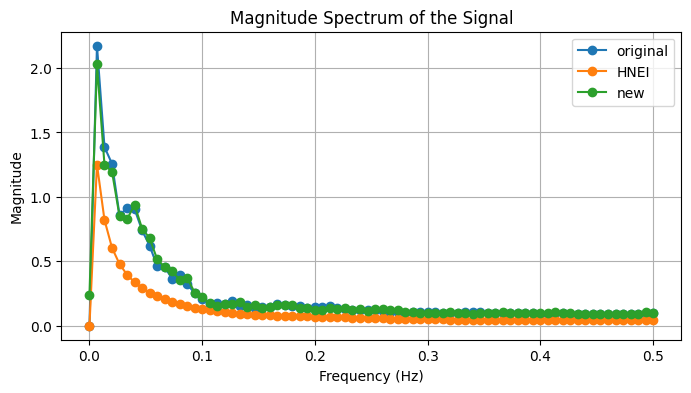

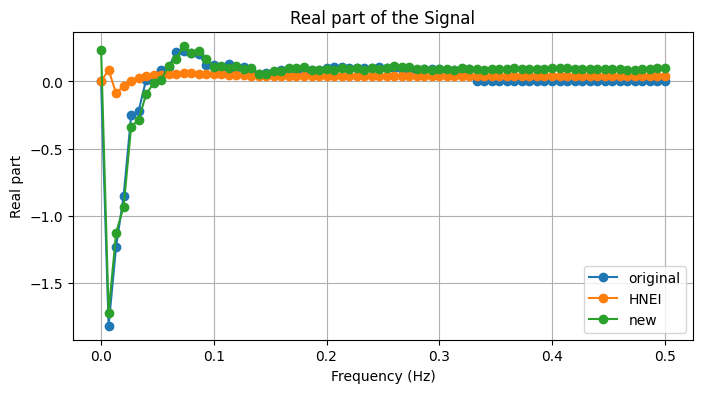

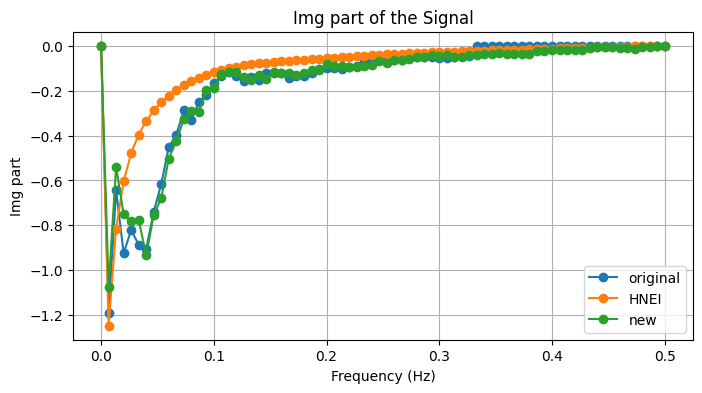

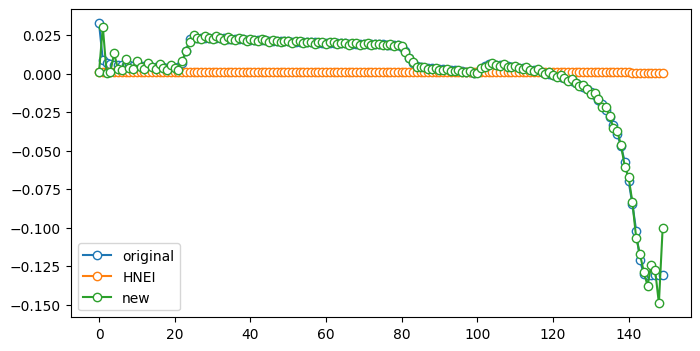

In [78]:
def resample_play(voltages):
    '''
    resample the charge and discharge curves
    :param voltages:charge or dicharge voltages
    :param currents: charge or discharge current
    :param capacity_in_battery: remaining capacities in the battery
    :return:interploted records
    '''
    charge_discharge_len = 300 // 2
    raw_bases = np.arange(1, len(voltages)+1)
    interp_bases = np.linspace(1, len(voltages)+1, num=charge_discharge_len,
                                    endpoint=True)
    interp_voltages = np.interp(interp_bases, raw_bases, voltages)
    return interp_voltages

voltages = resample_play(voltages) /3.7
voltages_tensor = torch.Tensor(voltages)
voltage_mean = torch.mean(voltages_tensor)
voltage_std = torch.sqrt(torch.var(voltages_tensor)+1e-5)
voltages_tensor = voltages_tensor - voltage_mean
voltages_tensor = voltages_tensor / voltage_std
fft_result = torch.fft.rfft(voltages_tensor)
# Get the magnitude of the FFT result
magnitude = torch.abs(fft_result)

# Create a corresponding frequency axis
frequencies = torch.fft.rfftfreq(voltages_tensor.size(0), d=1)
recovered_signal = torch.fft.irfft(fft_result, n=voltages_tensor.size(0))
fft_result[50:] = 0
an_recovered_signal = torch.fft.irfft(fft_result, n=voltages_tensor.size(0))
# create another voltage tensor from the same curve
X_target = generate_monotonic_sequence(len(voltages), 0, len(voltages)-1)
X_source = torch.arange(0, len(voltages))
another_voltages = linear_interpolate_multi(X_target, X_source, voltages_tensor.reshape(-1, 1))
another_voltages = another_voltages.reshape(-1)
an_fft_result = torch.fft.rfft(another_voltages)

# Get the magnitude of the FFT result
an_magnitude = torch.abs(an_fft_result)
print(an_magnitude.shape, an_magnitude.shape)
# Create a corresponding frequency axis
an_frequencies = torch.fft.rfftfreq(another_voltages.size(0), d=1)

voltages2 = resample_play(voltages2) / 4
voltages_tensor = torch.Tensor(voltages2)
voltage_mean = torch.mean(voltages_tensor)
voltage_std = torch.sqrt(torch.var(voltages_tensor)+1e-5)
voltages_tensor = voltages_tensor - voltage_mean
voltages_tensor = voltages_tensor / voltage_std
fft_result2 = torch.fft.rfft(voltages_tensor)
# Get the magnitude of the FFT result
magnitude2 = torch.abs(fft_result2)
frequencies2 = torch.fft.rfftfreq(voltages_tensor.size(0), d=1)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies.numpy(), magnitude.numpy(), label='original', marker='o')
plt.plot(frequencies2.numpy(), magnitude2.numpy(), label='HNEI', marker='o')
plt.plot(an_frequencies.numpy(), an_magnitude.numpy(), label='new', marker='o')
plt.title('Magnitude Spectrum of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()

# Plot the real part
plt.figure(figsize=(8, 4))
plt.plot(frequencies.numpy(), fft_result.real.numpy(), label='original', marker='o')
plt.plot(frequencies2.numpy(), fft_result2.real.numpy(), label='HNEI', marker='o')
plt.plot(an_frequencies.numpy(), an_fft_result.real.numpy(), label='new', marker='o')
plt.title('Real part of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Real part')
plt.grid(True)
plt.legend()
plt.show()

# Plot the img part
plt.figure(figsize=(8, 4))
plt.plot(frequencies.numpy(), fft_result.imag.numpy(), label='original', marker='o')
plt.plot(frequencies2.numpy(), fft_result2.imag.numpy(), label='HNEI', marker='o')
plt.plot(an_frequencies.numpy(), an_fft_result.imag.numpy(), label='new', marker='o')
plt.title('Img part of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Img part')
plt.grid(True)
plt.legend()
plt.show()



plt.figure(figsize=(8, 4))
plt.plot(recovered_signal, marker='o',markerfacecolor='white', label='original')
plt.plot(voltages2, marker='o',markerfacecolor='white', label='HNEI')
plt.plot(an_recovered_signal, marker='o',markerfacecolor='white', label='new')
plt.legend()
plt.show()

In [8]:
def resample_charge_discharge_curves(voltages, currents, capacity_in_battery):
    '''
    resample the charge and discharge curves
    :param voltages:charge or dicharge voltages
    :param currents: charge or discharge current
    :param capacity_in_battery: remaining capacities in the battery
    :return:interploted records
    '''
    charge_discharge_len = 300 // 2
    raw_bases = np.arange(1, len(voltages)+1)
    interp_bases = np.linspace(1, len(voltages)+1, num=charge_discharge_len,
                                    endpoint=True)
    interp_voltages = np.interp(interp_bases, raw_bases, voltages)
    interp_currents = np.interp(interp_bases, raw_bases, currents)
    interp_capacity_in_battery = np.interp(interp_bases, raw_bases, capacity_in_battery)
    return interp_voltages, interp_currents, interp_capacity_in_battery


In [9]:
import pickle
data_path = '/data/trf/python_works/Battery-LLM/dataset/MATR/MATR_b1c18.pkl'
data = pickle.load(open(data_path,'rb'))
prefix = data_path.split('/')[1]

cycle_data = data['cycle_data']
first_cycle_data = cycle_data[70]
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
nominal_capacity = data['nominal_capacity_in_Ah']
cycle_df = pd.DataFrame()
for key in need_keys:
    cycle_df[key] = first_cycle_data[key]
    
voltage_records = cycle_df['voltage_in_V'].values
current_records = cycle_df['current_in_A'].values
current_records_in_C = current_records/nominal_capacity
charge_capacity_records = cycle_df['charge_capacity_in_Ah'].values
discharge_capacity_records = cycle_df['discharge_capacity_in_Ah'].values

cutoff_voltage_indices = np.nonzero(current_records_in_C>=0.01) # This includes constant-voltage charge data, 49th cycle of MATR_b1c18 has some abnormal voltage records
charge_end_index = cutoff_voltage_indices[0][-1] # after charge_end_index, there are rest after charge, discharge, and rest after discharge data

cutoff_voltage_indices = np.nonzero(current_records_in_C<=-0.01) 
discharge_end_index = cutoff_voltage_indices[0][-1]




# tmp_discharge_capacity_records = max(charge_capacity_records) - discharge_capacity_records
if prefix in ['RWTH', 'OX']:
    # Every cycle first discharge and then charge
    #capacity_in_battery = np.where(charge_capacity_records==0, discharge_capacity_records, charge_capacity_records)
    original_discharge_voltages = discharge_voltages = voltage_records[:discharge_end_index]
    original_discharge_capacities = discharge_capacities = discharge_capacity_records[:discharge_end_index]
    original_discharge_currents = discharge_currents = current_records[:discharge_end_index]
    
    original_charge_voltages = charge_voltages = voltage_records[discharge_end_index:]
    original_charge_capacities = charge_capacities = charge_capacity_records[discharge_end_index:]
    original_charge_currents = charge_currents = current_records[discharge_end_index:]
    charge_current_in_C = charge_currents / nominal_capacity
    
    charge_voltages = charge_voltages[np.abs(charge_current_in_C)>0.01]
    charge_capacities = charge_capacities[np.abs(charge_current_in_C)>0.01]
    charge_currents = charge_currents[np.abs(charge_current_in_C)>0.01]
else:
    # Every cycle first charge and then discharge
    #capacity_in_battery = np.where(np.logical_and(current_records>=-(nominal_capacity*0.01), discharge_capacity_records<=nominal_capacity*0.01), charge_capacity_records, discharge_capacity_records)
    original_discharge_voltages = discharge_voltages = voltage_records[charge_end_index:]
    original_discharge_capacities = discharge_capacities = discharge_capacity_records[charge_end_index:]
    original_discharge_currents = discharge_currents = current_records[charge_end_index:]
    discharge_current_in_C = discharge_currents / nominal_capacity
    
    discharge_voltages = discharge_voltages[np.abs(discharge_current_in_C)>0.01]
    discharge_capacities = discharge_capacities[np.abs(discharge_current_in_C)>0.01]
    discharge_currents = discharge_currents[np.abs(discharge_current_in_C)>0.01]
    
    original_charge_voltages = charge_voltages = voltage_records[:charge_end_index]
    original_charge_capacities = charge_capacities = charge_capacity_records[:charge_end_index]
    original_charge_currents = charge_currents = current_records[:charge_end_index]

discharge_voltages, discharge_currents, discharge_capacities = resample_charge_discharge_curves(discharge_voltages, discharge_currents, discharge_capacities)
charge_voltages, charge_currents, charge_capacities = resample_charge_discharge_curves(charge_voltages, charge_currents, charge_capacities)
if prefix in ['RWTH', 'OX']:
    voltage_records = np.concatenate([discharge_voltages, charge_voltages], axis=0)
    current_records = np.concatenate([discharge_currents, charge_currents], axis=0)
    capacity_in_battery = np.concatenate([discharge_capacities, charge_capacities], axis=0)
else:
    voltage_records = np.concatenate([charge_voltages, discharge_voltages], axis=0)
    current_records = np.concatenate([charge_currents, discharge_currents], axis=0)
    capacity_in_battery = np.concatenate([charge_capacities, discharge_capacities], axis=0)


150


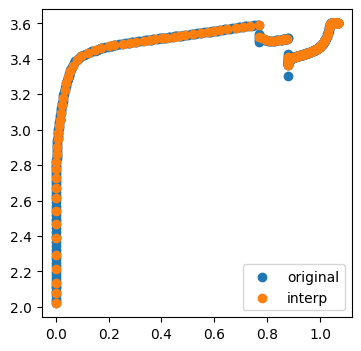

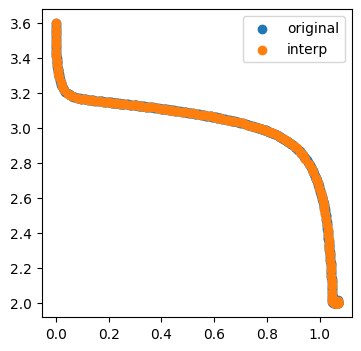

In [10]:
fig = plt.figure(figsize=(4,4))
plt.scatter(original_charge_capacities, original_charge_voltages, marker='o', label='original')
plt.scatter(charge_capacities, charge_voltages, marker='o', label='interp')
print(len(charge_capacities))
plt.legend()
# plt.scatter(capacity_in_battery[charge_end_index:], voltage_records[charge_end_index:], marker='x')
plt.show()

fig = plt.figure(figsize=(4,4))
plt.scatter(original_discharge_capacities, original_discharge_voltages, marker='o', label='original')
plt.scatter(discharge_capacities, discharge_voltages, marker='o', label='interp')
plt.legend()
# plt.scatter(capacity_in_battery[charge_end_index:], voltage_records[charge_end_index:], marker='x')
plt.show()


## Play with the freAug

150 150


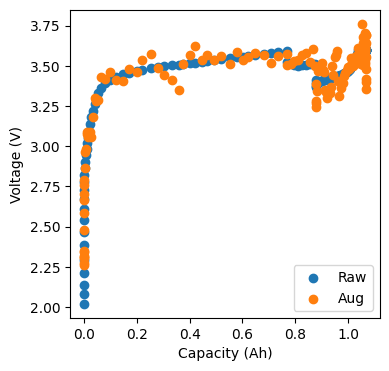

150 150


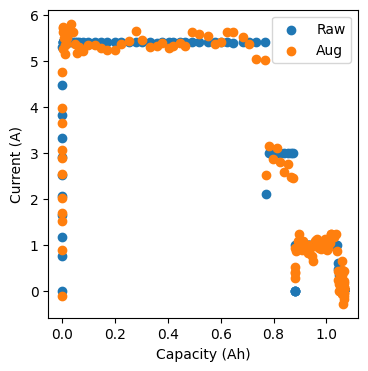

In [11]:
from utils.augmentation import BatchAugmentation_battery
import numpy as np
import torch
reshaped_charge_voltages = charge_voltages.reshape(1, len(charge_voltages))
batch_charge_voltages = np.concatenate([reshaped_charge_voltages,reshaped_charge_voltages], axis=0)
batch_charge_voltages = torch.Tensor(batch_charge_voltages).cuda()
aug_helper = BatchAugmentation_battery()
x = aug_helper.freq_mask(batch_charge_voltages)
aug_charge_voltages = x[0].cpu().numpy()
fig = plt.figure(figsize=(4,4))
print(len(aug_charge_voltages), len(charge_capacities))
plt.scatter(charge_capacities, charge_voltages, marker='o', label='Raw')
plt.scatter(charge_capacities, aug_charge_voltages, marker='o', label='Aug')
plt.ylabel('Voltage (V)')
plt.xlabel('Capacity (Ah)')
plt.legend()
plt.show()

reshaped_charge_currents = charge_currents.reshape(1, len(charge_currents))
batch_charge_currents = np.concatenate([reshaped_charge_currents,reshaped_charge_currents], axis=0)
batch_charge_currents = torch.Tensor(batch_charge_currents).cuda()
aug_helper = BatchAugmentation_battery()
x = aug_helper.freq_mask(batch_charge_currents)
aug_charge_currents = x[0].cpu().numpy()
fig = plt.figure(figsize=(4,4))
print(len(aug_charge_currents), len(charge_capacities))
plt.scatter(charge_capacities, charge_currents, marker='o', label='Raw')
plt.scatter(charge_capacities, aug_charge_currents, marker='o', label='Aug')
plt.ylabel('Current (A)')
plt.xlabel('Capacity (Ah)')
plt.legend()
plt.show()

In [14]:
labels = [1,1,1,2,2,3,4,5,5,6]
labels = [str(i) for i in labels]
df = pd.DataFrame()
df['label'] = labels
label_to_count = df["label"].value_counts()
weights = 1.0 / label_to_count[df["label"]]
weights = torch.DoubleTensor(weights.to_list())
weights

tensor([0.3333, 0.3333, 0.3333, 0.5000, 0.5000, 1.0000, 1.0000, 0.5000, 0.5000,
        1.0000], dtype=torch.float64)